In [116]:
# Imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from pytorch_metric_learning import losses, samplers
from random import randint
from skimage import io, transform
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import Sampler
from torchvision import datasets, models, transforms

In [117]:
# Configurations
# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Num epochs
num_epochs = 25

# Model 
model = models.resnet50()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Batch size
batch_size = 32

# Data set
train_path = '/lab/vislab/DATA/CUB/images/'

# Loss function
criterion = losses.TripletMarginLoss(margin=0.1)

In [140]:
class RandomMask(object):
    """Add random occlusions to image.

    Args:
        mask: (Image.Image) - Image to use to occlude.
    """

    def __init__(self, mask):
        assert isinstance(mask, Image.Image)
        self.mask = mask

    def __call__(self, sample):                    
        self.mask = self.mask.resize((64,64))
        theta = randint(0,45)
        print(theta)
        self.mask = self.mask.rotate(angle=theta)
        seed_x = randint(1,10)
        seed_y = randint(1,10)
        sample.paste(self.mask, (20*seed_x, 20*seed_y))

        return sample

32


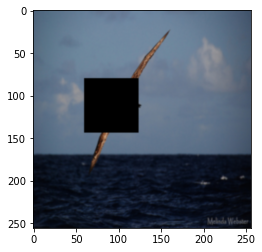

In [141]:
# Dataset

# occlusion transform?
mask = Image.open('/lab/vislab/DATA/masks/mask.png')

transformations = transforms.Compose([
    transforms.Resize((256,256)),
    RandomMask(mask), 
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(train_path, transformations)

plt.imshow(transforms.ToPILImage()(dataset[3][0]), interpolation="bicubic")

train_set, val_set = torch.utils.data.random_split(dataset, [5000, 1033])

In [114]:
from sklearn.manifold import TSNE

def map_features(outputs, labels, out_file):
    # create array of column for each feature output
    feat_cols = ['feature'+str(i) for i in range(outputs.shape[1])]
    # make dataframe of outputs -> labels
    df = pd.DataFrame(outputs, columns=feat_cols)
    df['y'] = labels
    df['labels'] = df['y'].apply(lambda i: str(i))
    # clear outputs and labels
    outputs, labels = None, None
    # creates an array of random indices from size of outputs
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    num_examples = 3000
    df_subset = df.loc[rndperm[:num_examples],:].copy()
    data_subset = df_subset[feat_cols].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    plt.scatter(
        x=df_subset["tsne-2d-one"],
        y=df_subset["tsne-2d-two"],
        c=df_subset["y"],
        s=3
    )
    plt.savefig(out_file, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [115]:
# Main Trainer
def train_model():
    """Generic function to train model"""

    start_time = datetime.now()
    correct = 0 
    incorrect = 0 
    num_batches = 0
    loss_values = []

    # Epochs 
    for epoch in range(num_epochs): 
        print("epoch num:", epoch)
        
        train_sampler = torch.utils.data.RandomSampler(train_set)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
        
        running_outputs = torch.FloatTensor().cpu()
        running_labels = torch.LongTensor().cpu()
        running_loss = 0.0
        model.train()
        
        # Batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):             
            num_batches += 1
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

            loss = criterion(output, labels)
            loss = Variable(loss, requires_grad = True)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1

        running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
        running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)


        print(running_loss / num_batches)
        print("Correct", correct)
        print("Incorrect", incorrect)

        # t-SNE
        map_features(running_outputs, running_labels, "outfile")
        # Loss Plot            
        loss_values.append(running_loss / num_batches)

        time_elapsed = datetime.now() - start_time 
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

    plt.plot(loss_values)    
    return model, running_loss

In [6]:
# Debugging
def test():
    trained_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        j = 0
        corrects = 0
        pairs = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = trained_model(data)
            
            print(output.shape)
            break
            
#             test_loss =  criterion(dista, distb, target).data.item()

            for row in output: 
                distance_matrix = accuracy(row)
                pairs.append(distance_matrix)
                print(pairs[0])
            d = distance_matrix.cpu().numpy()
            print(type(d))
            print(d.shape)
            
            print(min(d))

In [7]:
# Run Script
model.to(device)

trained_model, loss = train_model()
print(loss)

epoch num: 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 2; 15.78 GiB total capacity; 5.21 GiB already allocated; 34.69 MiB free; 5.28 GiB reserved in total by PyTorch)